## CS6460 data analysis

### 1. Data preparation and summary stats

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import seaborn as sns
import csv
import math
from collections import Counter
import scipy.stats as ss
import sklearn.preprocessing as sp
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from subprocess import check_output

%matplotlib inline

In [4]:
#ingest raw mixed numerical and categorical data produced by AMT study
data = pd.read_csv("data_categorical.csv")
#list data types
data.dtypes

Code      object
answer    object
scale      int64
why       object
dtype: object

In [5]:
data.shape

(132, 4)

### Convert categorical data to int using one hot encoding

In [6]:
# drop "why" column since this will be dealt with separately using NLP
data = data.drop(['why'], axis=1)

In [7]:
# convert to categorical using one hot encoding
#data = pd.get_dummies(data, columns=["Code", "answer"]).head()
data = pd.get_dummies(data, dummy_na=True)
data

,scale,Code_causal,Code_contrastive,Code_example,Code_nan,answer_Charts,answer_Images,answer_Text,answer_nan
0,5,1,0,0,0,0,0,1,0
1,5,1,0,0,0,1,0,0,0
2,4,1,0,0,0,0,0,1,0
3,4,1,0,0,0,0,0,1,0
4,4,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...
127,4,0,0,1,0,0,0,1,0
128,5,0,0,1,0,0,0,1,0
129,5,0,0,1,0,0,0,1,0
130,3,0,0,1,0,0,0,1,0


In [8]:
#verify that encoding worked.  Expected data shape should be 132, 9
data.shape

(132, 9)

In [9]:
#create separate frames for each column
causal = pd.DataFrame(data, columns=['Code_causal'])
contrastive = pd.DataFrame(data, columns=['Code_contrastive'])
example = pd.DataFrame(data, columns=['Code_example'])
charts = pd.DataFrame(data, columns=['answer_Charts'])
images = pd.DataFrame(data, columns=['answer_Images'])
text = pd.DataFrame(data, columns=['answer_Text'])

### Display data

In [22]:
#group answer types by scale across all three explanation types
data.groupby('scale').mean()

,Code_causal,Code_contrastive,Code_example,Code_nan,answer_Charts,answer_Images,answer_Text,answer_nan
scale,,,,,,,,
1,0.000000,0.000000,1.000000,0.0,0.333333,0.000000,0.666667,0.0
2,0.000000,0.666667,0.333333,0.0,0.333333,0.000000,0.666667,0.0
3,0.136364,0.272727,0.590909,0.0,0.136364,0.409091,0.454545,0.0
4,0.379310,0.413793,0.206897,0.0,0.258621,0.362069,0.379310,0.0
5,0.326087,0.413043,0.260870,0.0,0.195652,0.130435,0.673913,0.0


### 2. Plot answer by scale to compare answers across all question types (contrastive, causal, example)

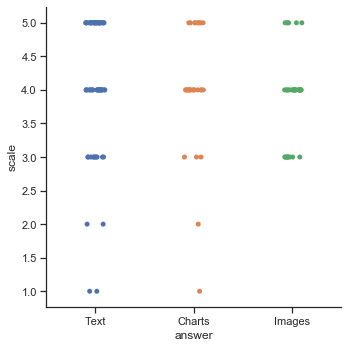

In [11]:
# this simplistic view doesn't take into account dimensionality but it's a first look at how data is distributed
sns.set(style="ticks", color_codes=True)
d = pd.read_csv("data_categorical.csv", index_col=0)
sns.catplot(x="answer", y="scale", jitter=True, data=d);

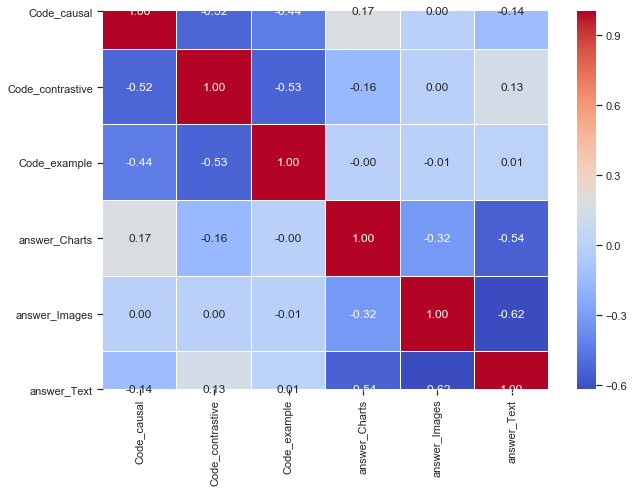

In [12]:
# Correlation Matrix Heatmap
data_dropped = data.drop(['Code_nan', 'scale', 'answer_nan'], axis=1)
f, ax = plt.subplots(figsize=(10, 6))
corr = data_dropped.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f',
                 linewidths=.05)
f.subplots_adjust(top=1)

### 3. Fit a OLS linear model

In [13]:
lm = ols('Code_causal ~ answer_Text',data=data).fit()
table = sm.stats.anova_lm(lm)
print(table)

                df     sum_sq   mean_sq         F    PR(>F)
answer_Text    1.0   0.561222  0.561222  2.670767  0.104626
Residual     130.0  27.317566  0.210135       NaN       NaN


In [14]:
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(data['Code_causal'], data['Code_contrastive'], data['Code_example'], data['answer_Charts'], data['answer_Images'], data['answer_Text'])
print(fvalue, pvalue)

6.27674127126231 1.0111250432816701e-05


### 4. Covariance matrix to check for significant difference in means

In [15]:
x = contrastive
y = causal


# Normal distributed x and y vector with mean 0 and standard deviation 1
#x = np.random.normal(0, 1, 500)
#y = np.random.normal(0, 1, 500)
X = np.vstack((x, y)).T



# Covariance
def cov(x, y):
    xbar, ybar = x.mean(), y.mean()
    return np.sum((x - xbar)*(y - ybar))/(len(x) - 1)

# Covariance matrix
def cov_mat(X):
    return np.array([[cov(X[0], X[1]), cov(X[0], X[0])], \
                     [cov(X[0], X[0]), cov(X[0], X[1])]])

In [16]:
#Thiels U coefficient for covariance of mixed numerical and categorical data.  
#Author: Shakedzy https://www.kaggle.com/shakedzy/alone-in-the-woods-using-theil-s-u-for-survival

def conditional_entropy(x,y):
    # entropy of x given y
    y_counter = Counter(y)
    xy_counter = Counter(list(zip(x,y)))
    total_occurrences = sum(y_counter.values())
    entropy = 0
    for xy in xy_counter.keys():
        p_xy = xy_counter[xy] / total_occurrences
        p_y = y_counter[xy[1]] / total_occurrences
        entropy += p_xy * math.log(p_y/p_xy)
    return entropy

def theil_u(x,y):
    s_xy = conditional_entropy(x,y)
    x_counter = Counter(x)
    total_occurrences = sum(x_counter.values())
    p_x = list(map(lambda n: n/total_occurrences, x_counter.values()))
    s_x = ss.entropy(p_x)
    if s_x == 0:
        return 1
    else:
        return (s_x - s_xy) / s_x



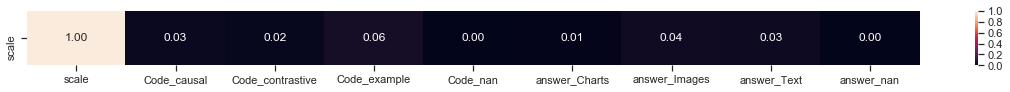

In [17]:
theilu = pd.DataFrame(index=['scale'],columns=data.columns)
columns = data.columns
for j in range(0,len(columns)):
    u = theil_u(data['scale'].tolist(),data[columns[j]].tolist())
    theilu.loc[:,columns[j]] = u
theilu.fillna(value=np.nan,inplace=True)
plt.figure(figsize=(20,1))
sns.heatmap(theilu,annot=True,fmt='.2f')
plt.show()

In [18]:
#create separate frames for each column
causal = pd.DataFrame(data, columns=['Code_causal'])
contrastive = pd.DataFrame(data, columns=['Code_contrastive'])
example = pd.DataFrame(data, columns=['Code_example'])
charts = pd.DataFrame(data, columns=['answer_Charts'])
images = pd.DataFrame(data, columns=['answer_Images'])
text = pd.DataFrame(data, columns=['answer_Text'])

pd.crosstab(data['Code_causal'], data['answer_Text'])

#chi2 = np.array([causal, contrastive, example, charts, images, text])

answer_Text,0,1
Code_causal,,
0,41,51
1,24,16


In [19]:
# Import the function
from scipy.stats import chi2_contingency#Testing the relationship

chi_res = chi2_contingency(pd.crosstab(data['Code_causal'], data['answer_Text']))
print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 2.075608246393452, p-value: 0.14967026352707827


In [20]:
chi2_check = []
for i in categorical_columns:
    if chi2_contingency(pd.crosstab(loan['Loan_Status'], loan[i]))[1] < 0.05:
        chi2_check.append('Reject Null Hypothesis')
    else:
        chi2_check.append('Fail to Reject Null Hypothesis')res = pd.DataFrame(data = [categorical_columns, chi2_check] 
             ).T 
res.columns = ['Column', 'Hypothesis']
print(res)

SyntaxError: invalid syntax (<ipython-input-20-6ab7fe13cdd3>, line 6)